In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralhydrology.nh_run import eval_run
import pickle
from pathlib import Path
import os
from tqdm import tqdm


class Evaluation():
    
    """
    A class for evaluating a model trained by `Neuralhydrology` library
    -------------------
    Requirements:
        - A proper .txt file listing test basin id
        - A proper configuration (.yml) file specifing the test file and date
        - A folder consisting of .csv files of the test basin data with proper observed values
        
    -------------------
    Model Parameters:
        - run_dir: str
            Name of the directory for the target model
            
        - epoch_num: int
            The number of epoch to be evaluated
            
        - csv_dir: str
            The directory of the original csv files
            
        - eval_list:
            The name of the .txt file consisting of the basin list to be evaluated
            
        - mean: float
            A mean value used for standardizing the target variable
            
        - var: float
            A variance value used for standardizing the target variable
            
        - test_start_date: str
            Date to start evaluation 'dd/mm/yyyy`
            
        - test_end_date: str
            Date to end evaluation 'dd/mm/yyyy'
            
        - skip_sim: bool
            Whether to skip simulation - default to false, enable this option when simulation is already done
            
        - apply_trainsformation: bool
            Whether to apply inverse transformation - default to true, enable this when the standardization is not applied to the data
            
        - target_var: str
            Name of the target variable - default to "discharge"
    
    -------------------   
    Member Functions:
        public:
        - plot_validation() -> None:
            plot the validation error progress during training
            
        - get_validation -> pd.DataFrame:
            returns a dataframe of validation errors for each epoch
            
        - get_prediction(basin_id: str) -> float, np.array:
            returns the simulated discharge for the specified basin
            
        - get_nse(basin_list: str = test.txt) -> pd.DataFrame:
            returns a dataframe of the simulated nse values for the listed basins
            
        - plot_prediction(basin_id: str) -> None: 
            plot the simulated vs observed discharge (or target) values for a single basin
            
        - plot_nse_distribution(ignore_neg = True) -> None:
            plot the distribution of nse values over multiple basins, excluding/not excluding negative nse values
            
        private:
        - __evalute_single__() -> float:
            evaluates a single basin and returns nse value
            
        - __evaluate__() -> pd.DataFrame:
            runs evaluation on the basins listed in eval_list and returns the result dataframe
            
        - __collect_validation__() -> pd.DataFrame:
            collect the mean, median, max values for validation metics for each epoch
    """
    
    def __init__(self, run_dir: str, 
                 epoch_num: int, 
                 csv_dir: str = "data/csv_files",
                 eval_list: str = r"basin_list\US_basin_list.txt",
                 mean: float = 0.8561527661255196,
                 var: float = 5.06157279557463,
                 test_start_date: str = '01/01/2011',
                 test_end_date: str = '31/12/2022',
                 skip_sim: bool = False,
                 apply_transformation: bool = True,
                 target_var: str = "discharge"
                 ):
        
        self.run_dir = run_dir
        self.epoch_num = epoch_num
        self.csv_dir = csv_dir
        self.eval_list = eval_list
        self.mean = mean
        self.var = var
        self.test_start_date = pd.to_datetime(test_start_date, format='%d/%m/%Y')
        self.test_end_date = pd.to_datetime(test_end_date, format='%d/%m/%Y')
        self.skip_sim = skip_sim
        self.apply_transformation = apply_transformation
        self.target_var = target_var
        self.test_name = f"evaluate {run_dir} epoch {epoch_num}"

        # Ensure the run directory exists
        self.run_dir = Path("runs/" + run_dir)
        if not os.path.exists(self.run_dir):
            raise FileNotFoundError(f"The specified run directory does not exist: {self.run_dir}")

        # Ensure the CSV directory exists
        if not os.path.exists(self.csv_dir):
            raise FileNotFoundError(f"The specified CSV directory does not exist: {self.csv_dir}")
        
        # Ensure the eval_list directory exists
        if not os.path.exists(self.eval_list):
            raise FileNotFoundError(f"The specified evaluation list directory does not exist: {self.eval_list}")
        
        if not skip_sim:
            eval_run(run_dir = self.run_dir, period = "test")
            
        self.__result_df: pd.DataFrame = self.__evaluate__(self.eval_list)
        self.__validation_df: pd.DataFrame = self.__collect_validation__()
        
    
    def __evaluate_single__(self, basin_id: str):
        

        # set the epoch number
        epoch_num = str(self.epoch_num)
        if len(epoch_num) == 1:
            epoch_num = "model_epoch00" + epoch_num
        elif len(epoch_num) == 2:
            epoch_num = "model_epoch0" + epoch_num
        else:
            epoch_num = "model_epoch" + epoch_num
            
        with open(self.run_dir / "test" / epoch_num / "test_results.p", "rb") as fp:
            results = pickle.load(fp)
        
         # simulated values
        qsim = results[basin_id]['1D']['xr']['discharge_sim']
        sim = qsim.values
        dates = qsim['date'].values
        
        if self.apply_transformation:
            sim = (sim * np.sqrt(self.var)) + self.mean
            
            sim = np.exp(sim) - 1e-6
            
        csv_file_path = Path(self.csv_dir) / f"{basin_id}.csv"
        df = pd.read_csv(csv_file_path, index_col='date', parse_dates=True).loc[self.test_start_date:self.test_end_date, [self.target_var]]
        
        obs = df[self.target_var].values
        
        obs_sim_df = pd.DataFrame({
            'date': dates,
            'observed': obs.flatten(),
            'simulated': sim.flatten()
        })
        
        # drop rows with missing values
        obs_sim_df = obs_sim_df.dropna()
        
        # calculate nse
        observed_values = obs_sim_df['observed'].values
        simulated_values = obs_sim_df['simulated'].values
        dates = obs_sim_df['date']
        
        mean_observed = np.mean(observed_values)
        sum_squared_diff = sum((obs - sim) ** 2 for obs, sim in zip(observed_values, simulated_values))
        mean_observed = np.mean(observed_values)
        sum_squared_diff_mean = sum((obs - mean_observed) ** 2 for obs in observed_values)
        nse = None
        
        if sum_squared_diff_mean == 0:
        # Observed data is constant => no variability => NSE is undefined
            nse = np.nan  # or some sentinel value
        else:
            nse = 1 - (sum_squared_diff / sum_squared_diff_mean)
            nse = nse.item()
            
        return nse, simulated_values, observed_values, dates
        
    def __evaluate__(self, eval_list: str):
        
        with open(eval_list, 'r') as file:
            basin_ids = file.read().splitlines()
            
        nse_values = []
        
        print("Collecting NSE values")
        for basin_id in tqdm(basin_ids):
            nse, _, _, _ = self.__evaluate_single__(basin_id)
            nse_values.append(nse)
        
        nse_df = pd.DataFrame({'basin_id': basin_ids, 'NSE': nse_values})
        nse_df['Performance'] = nse_df['NSE'].apply(lambda x: 'Excellent' if x > 0.75 else 'Good' if x >= 0.36 else 'Unsatisfactory' if x >= 0 else 'Negative')
        
        return nse_df
    
    def __collect_validation__(self):
        validation_folder = self.run_dir / "validation"
        
        epoches = []
        mean_nse_values = []
        median_nse_values = []
        max_nse_values = []

        print("Collecting validation metrics")
        for epoch in range(1, self.epoch_num + 1):
            epoches.append(epoch)
            epoch_folder = os.path.join(validation_folder, f"model_epoch{epoch:03d}")
            csv_file = os.path.join(epoch_folder, "validation_metrics.csv")

            if os.path.exists(csv_file):
                df = pd.read_csv(csv_file)
                mean_nse = df["NSE"].dropna().mean()
                median_nse = df["NSE"].dropna().median()
                max_nse = df["NSE"].dropna().max()
                mean_nse_values.append(mean_nse)
                median_nse_values.append(median_nse)
                max_nse_values.append(max_nse)
            else:
                mean_nse_values.append(None)
                median_nse_values.append(None)
                max_nse_values.append(None)
                
        validation_df = pd.DataFrame({
            "epoch" : epoches,
            "mean_nse": mean_nse_values,
            "median_nse": median_nse_values,
            "max_nse": max_nse_values
        })
        
        return validation_df
    
    def __str__(self):
        self.print_summary()
        return self.test_name
    
    def plot_validation(self, plot_type: str = "Median"):
        
        validation_values = None
        if plot_type == "Median":
            validation_values = self.__validation_df["median_nse"]
        elif plot_type == "Mean":
            validation_values = self.__validation_df["mean_nse"]
        elif plot_type == "Max":
            validation_values = self.__validation_df["max_nse"]
        else:
            raise ValueError(f"Incorrect plot type: {plot_type}. Expected 'Median', 'Mean', or 'Max'.")
        
        plt.figure(figsize=(10, 6))
        epochs = range(1, len(validation_values) + 1)
        plt.plot(epochs, validation_values, marker='o', label=f'{plot_type} NSE')
        plt.xlabel("Epoch")
        plt.ylabel(f"{plot_type} NSE")
        plt.title(f"Validation {plot_type} NSE Progress")
        plt.grid(True)
        plt.legend()
        plt.show()
        
    def get_prediction(self, basin_id: str):
        
        nse, pred, _, _ = self.__evaluate_single__(basin_id)
        
        return nse, pred
    
    def get_nse(self):
        return self.__result_df
    
    def plot_prediction(self, basin_id: str):
        
        nse, sim, obs, date = self.__evaluate_single__(basin_id)
        
        
        plt.figure(figsize=(14, 7))
        plt.plot(date, obs, label='Observed')
        plt.plot(date, sim, label='Simulated')
        plt.xlabel('Date')
        plt.ylabel('Discharge')
        plt.title(f'Basin {basin_id} Observed vs Simulated - NSE: {nse}')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def print_summary(self):
        print(f"Summary Statistic: \n{self.__result_df['NSE'].replace(-np.inf, np.nan).dropna().describe()}\n")
        print(f"Performance Summary: \n{self.__result_df['Performance'].value_counts()}\n")
        
        
    def plot_nse_distribution(self, ignore_neg=True): 
        nse_values = self.__result_df['NSE'].replace(-np.inf, np.nan).dropna()
        
        if ignore_neg:
            nse_values = nse_values[nse_values >= 0]
        
        # Plot: Box plot
        plt.figure(figsize=(10, 6))
        plt.boxplot(nse_values, vert=True, patch_artist=True, labels=['NSE'])
        plt.title("Distribution of NSE Values Across Subbasins")
        plt.ylabel("NSE")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

        # Plot: Histogram
        plt.figure(figsize=(10, 6))
        plt.hist(nse_values, bins=10, edgecolor='black', alpha=0.7)
        plt.title("Histogram of NSE Values Across Subbasins")
        plt.xlabel("NSE")
        plt.ylabel("Frequency")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
        
        

In [23]:
eval_list: str = r"basin_list\US_basin_list.txt"
run_dir = "GAGEii-ALL_US_with_static_z_standardized_1902_141922"
epoch_num = 89

evaluator = Evaluation(run_dir=run_dir, epoch_num=epoch_num, skip_sim=True)

 96%|█████████▌| 382/399 [00:30<00:01, 13.01it/s]C:\Users\ybrot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ybrot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 399/399 [00:32<00:00, 12.40it/s]

In [24]:
df = evaluator.get_nse()

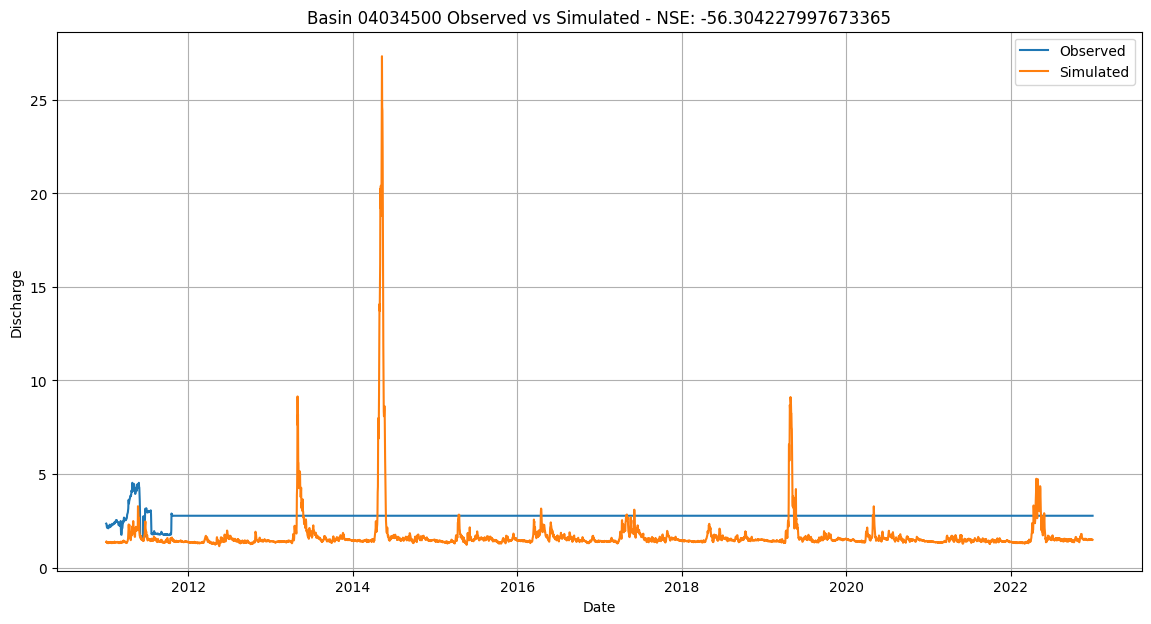

In [25]:
evaluator.plot_prediction("04034500")

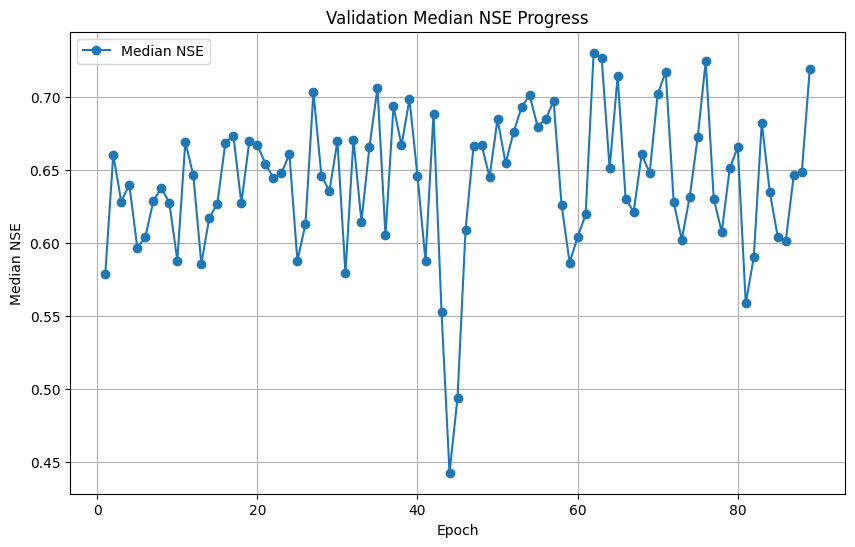

In [26]:
evaluator.plot_validation()

In [27]:
df['NSE'].replace(-np.inf, np.nan).dropna().describe()

count    3.580000e+02
mean    -1.915644e+32
std      2.591053e+33
min     -4.796642e+34
25%     -2.365484e-01
50%      6.110742e-01
75%      7.575207e-01
max      8.983961e-01
Name: NSE, dtype: float64

In [30]:
print(evaluator)

Summary Statistic: 
count    3.580000e+02
mean    -1.915644e+32
std      2.591053e+33
min     -4.796642e+34
25%     -2.365484e-01
50%      6.110742e-01
75%      7.575207e-01
max      8.983961e-01
Name: NSE, dtype: float64

Performance Summary: 
Performance
Negative          153
Good              124
Excellent          95
Unsatisfactory     27
Name: count, dtype: int64

evaluate GAGEii-ALL_US_with_static_z_standardized_1902_141922 on 89


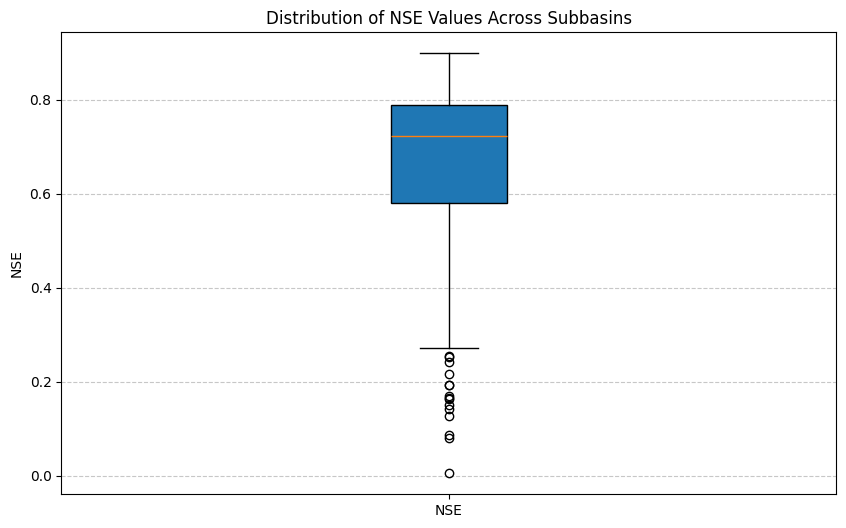

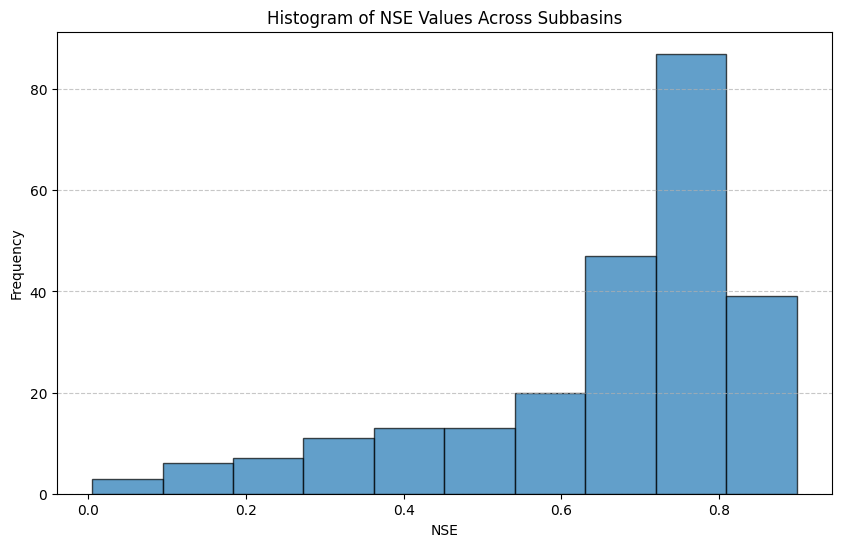

In [29]:
evaluator.plot_nse_distribution()